In [1]:
import os 
import sys
import json
import pickle

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Define the path to the dataset
base_path = os.path.join(os.path.dirname(os.getcwd()))
base_path

'/root/geonhee/PlayerImputer'

In [2]:
from datatools.trace_snapshot import TraceSnapshot
from datatools.utils import compute_camera_coverage, is_inside
import imputer.config as config

In [3]:
# 데이터 및 모델 경로
data_dir = os.path.join(base_path, "data" ,"DFL")
model_path = os.path.join(base_path, "stores", "transformer", '054') # 036, 059
params_path = os.path.join(model_path, "params.json")

with open(params_path, "r") as f:
    params = json.load(f)

params["save_path"] = model_path 
params

{'ModelConfig': {'dim_hidden': 128,
  'num_heads': 16,
  'num_layers': 1,
  'dropout': 0.2,
  'dim_feedforward': 256,
  'ln': True},
 'DataConfig': {'batch_size': 32,
  'num_workers': 80,
  'pin_memory': True,
  'prefetch_factor': 2},
 'TrainerConfig': {'max_epochs': 200,
  'min_epochs': 100,
  'accelerator': 'gpu',
  'gradient_clip_val': 5.0,
  'check_val_every_n_epoch': 1},
 'OptimizerConfig': {'optimizer_params': {'lr': 0.0001,
   'weight_decay': 1e-05}},
 'EarlyStopConfig': {'patience': 5,
  'min_delta': 1e-05,
  'mode': 'min',
  'strict': False,
  'verbose': True},
 'ModelCheckpoint': {'save_top_k': 1, 'verbose': True, 'mode': 'min'},
 'save_path': '/root/geonhee/PlayerImputer/stores/transformer/054'}

In [4]:
args_path = os.path.join(model_path, "args.json")
with open(args_path, "r") as f:
    args = json.load(f)
args

{'mode': 'train',
 'model': 'transformer',
 'trial': 54,
 'data_verion': 52,
 'params_file': 'imputer_params.json',
 'data_dir': 'data/DFL',
 'window': 41,
 'xfns': ['prevAgentX',
  'prevAgentY',
  'prevAgentTime',
  'nextAgentX',
  'nextAgentY',
  'nextAgentTime',
  'avgAgentX',
  'avgAgentY',
  'agentSide',
  'agentRole',
  'agentObserved',
  'goalDiff',
  'eventX',
  'eventY',
  'eventType',
  'freeze_frame',
  'observeEventX',
  'observeEventY',
  'prevAvgX',
  'prevAvgY',
  'nextAvgX',
  'nextAvgY',
  'possessRatio',
  'elapsedTime'],
 'yfns': ['coordinates'],
 'use_transform': True,
 'play_left_to_right': True}

In [5]:
import ast
from datatools.preprocess import extract_match_id
from imputer.datasets import ImputerDataset

data_dir = os.path.join(base_path, args["data_dir"], args["model"], f'window{args["window"]}', f'version_{args["data_verion"]:03d}', 'test_info.txt')

with open(data_dir, "r") as f:
    for line in f:
        if line.startswith("Game IDs:"):
            # "Game IDs: " 뒷부분만 추출
            list_str = line.split(":", 1)[1].strip()
            # 문자열을 리스트로 변환 (ast.literal_eval 안전하게 사용)
            test_game_ids = ast.literal_eval(list_str)

test_game_ids

['DFL-MAT-J03YKM']

In [6]:
dataset_pkl_path = os.path.join(base_path, "data", "DFL", args["model"], f'window{args["window"]}', f'version_{args["data_verion"]:03d}', 'test_dataset.pkl')

with open(dataset_pkl_path, "rb") as f:
    test_dataset = pickle.load(f)
test_dataset

In [7]:
test_dataset.events

,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,team,game_id,start_x,start_y,position,related_x,related_y,related_id,event_id,freeze_frame
0,KickOff_Play_Pass,0.000,DFL-CLU-00000V,DFL-OBJ-J01GLO,NaN,2024-04-06 15:30:00.520000+02:00,0.0,0.0,"{'TeamLeft': 'DFL-CLU-00000B', 'GameSection': ...",1,Home,DFL-MAT-J03YKM,53.130000,33.490000,STR,52.330000,35.050000,DFL-OBJ-J01GUA,0,"[[H00, 46.92, 27.310000000000002, False, True,..."
1,Play_Pass,0.739,DFL-CLU-00000V,DFL-OBJ-J01GUA,NaN,2024-04-06 15:30:01.259000+02:00,0.0,0.0,"{'PlayOrigin': 'ownHalf', 'FromOpenPlay': 'tru...",1,Home,DFL-MAT-J03YKM,52.080015,35.520030,HL,30.130038,29.559939,DFL-OBJ-J01GQO,1,"[[H00, 47.8, 28.049999999999997, False, True, ..."
2,Play_Pass,5.732,DFL-CLU-00000V,DFL-OBJ-J01GQO,NaN,2024-04-06 15:30:06.252000+02:00,0.0,5.0,"{'PlayOrigin': 'ownHalf', 'FromOpenPlay': 'tru...",1,Home,DFL-MAT-J03YKM,40.370077,31.630034,IVR,73.760024,63.869966,DFL-OBJ-J019PZ,2,"[[H00, 58.64, 33.57, False, True, False], [H01..."
3,TacklingGame,7.630,DFL-CLU-00000V,DFL-OBJ-J019PZ,0.0,2024-04-06 15:30:08.150000+02:00,0.0,7.0,"{'LoserRole': 'withoutBallControl', 'Winner': ...",1,Home,DFL-MAT-J03YKM,73.450012,63.559988,DLM,75.159968,60.909996,DFL-OBJ-J01XCM,3,"[[H00, 62.16, 39.0, False, True, False], [H01,..."
4,Play_Pass,7.910,DFL-CLU-00000V,DFL-OBJ-J019PZ,NaN,2024-04-06 15:30:08.430000+02:00,0.0,7.0,"{'PlayOrigin': 'oppositionHalf', 'FromOpenPlay...",1,Home,DFL-MAT-J03YKM,73.230016,63.620012,DLM,81.459988,56.750024,DFL-OBJ-J01D3P,4,"[[H00, 62.82, 39.16, False, True, False], [H01..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,TacklingGame,3104.460,DFL-CLU-00000V,DFL-OBJ-J01GQO,1.0,2024-04-06 17:31:49.790000+02:00,51.0,44.0,"{'LoserRole': 'withBallControl', 'Winner': 'DF...",2,Home,DFL-MAT-J03YKM,101.200064,37.509952,IVR,101.470064,37.449968,DFL-OBJ-0026NY,1644,"[[H00, nan, nan, False, True, False], [H01, 99..."
1645,OtherBallAction,3105.928,DFL-CLU-00000B,DFL-OBJ-0026NY,NaN,2024-04-06 17:31:51.258000+02:00,51.0,45.0,"{'BallPossessionPhase': '1652', 'Player': 'DFL...",2,Away,DFL-MAT-J03YKM,0.859987,31.560006,TW,NaN,NaN,NaN,1645,"[[H00, nan, nan, False, False, False], [H01, 9..."
1646,OtherBallAction,3107.672,DFL-CLU-00000B,DFL-OBJ-J016J2,NaN,2024-04-06 17:31:53.002000+02:00,51.0,47.0,"{'BallPossessionPhase': '1653', 'Player': 'DFL...",2,Away,DFL-MAT-J03YKM,11.400003,24.430000,DLM,NaN,NaN,NaN,1646,"[[H00, nan, nan, False, False, False], [H01, 9..."
1647,TacklingGame,3109.336,DFL-CLU-00000V,DFL-OBJ-J01DKU,1.0,2024-04-06 17:31:54.666000+02:00,51.0,49.0,"{'LoserRole': 'withBallControl', 'Winner': 'DF...",2,Home,DFL-MAT-J03YKM,93.149974,42.370000,STZ,93.690000,43.580000,DFL-OBJ-J016J2,1647,"[[H00, nan, nan, False, True, False], [H01, 91..."


In [ ]:
# test_dataset1 = ImputerDataset(
#     game_ids=test_game_ids,
#     data_dir=args["data_dir"],
#     window=args["window"],
#     model=args["model"],
#     xfns=args["xfns"],
#     yfns=args["yfns"],
#     play_left_to_right=args["play_left_to_right"],
#     use_transform=args["use_transform"],
#     transform=test_dataset.transform
# )

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
checkpoint_path = os.path.join(model_path, "best_model.ckpt")
checkpoint_path

'/root/geonhee/PlayerImputer/stores/transformer/054/best_model.ckpt'

In [9]:
from imputer.components.model import SetTransformerModel

model=SetTransformerModel(test_dataset, params["ModelConfig"], params["OptimizerConfig"])
model


[모델 요약 정보]

총 학습 가능한 파라미터 수: 1,689,008



SetTransformerModel(
  (model): SetTransformer(
    (categorical_embeddings): ModuleDict(
      (agentObserved): Embedding(3, 1, padding_idx=0)
      (agentRole): Embedding(28, 5, padding_idx=0)
      (agentSide): Embedding(3, 1, padding_idx=0)
      (eventType): Embedding(47, 6, padding_idx=0)
    )
    (input_fc): Linear(in_features=32, out_features=128, bias=True)
    (freeze_fc): Linear(in_features=5, out_features=128, bias=True)
    (snapshot_encoder1): CustomTransformerEncoder(
      (layers): ModuleList(
        (0): CustomTransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=1024, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=1024, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        

In [10]:
from imputer.components.press import SetTransformerComponent
component = SetTransformerComponent(
    model=model,
    params=params,
)
component.load(checkpoint_path)
component

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


🔥 Loading model from /root/geonhee/PlayerImputer/stores/transformer/054/best_model.ckpt


In [11]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"총 파라미터 수: {total:,}")
    print(f"학습 가능한 파라미터 수: {trainable:,}")
    return total, trainable

count_parameters(model)

총 파라미터 수: 1,689,008
학습 가능한 파라미터 수: 1,689,008


(1689008, 1689008)

In [12]:
df = component.predict(test_dataset)
df

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

x_error: 0.03930770233273506, y_error: 0.06256148964166641, 
euc_distance: 6.635594367980957
Accuracy: 72.35171285061234
x: 4.127, y: 4.254, xy: 6.636


,pred,target
0,"{'A00': (10.090045928955078, 33.85322189331055...","{'A00': (2.940000057220459, 33.93000030517578)..."
1,"{'A00': (9.762303352355957, 33.8808708190918),...","{'A00': (5.070000171661377, 33.95000076293945)..."
2,"{'A00': (8.317106246948242, 34.39284896850586)...","{'A00': (9.630000114440918, 30.309999465942383..."
3,"{'A00': (4.37031888961792, 32.18988037109375),...","{'A00': (6.610000133514404, 30.170000076293945..."
4,"{'A00': (4.199883937835693, 31.99799156188965)...","{'A00': (6.119999885559082, 30.40999984741211)..."
...,...,...
1644,"{'A00': (-1.171768069267273, 33.16094589233398...","{'A00': (3.5299997329711914, 30.54999923706054..."
1645,"{'A00': (-0.7463394999504089, 31.8669910430908...","{'A00': (0.8600000143051147, 31.55999946594238..."
1646,"{'A00': (-0.18585282564163208, 32.295921325683...","{'A00': (1.3600000143051147, 32.29999923706055..."
1647,"{'A00': (-0.7098384499549866, 33.0688705444335...","{'A00': (1.5700000524520874, 36.77999877929687..."


In [13]:
df1 = component.predict_freeze_frame1(test_dataset)
df1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

x: 3.421, y: 3.594, xy: 5.559
Accuracy1: 62.692509167103196
Accuracy2: 62.692509167103196
----Error In Camera----
x: 2.102064315394746, y: 2.6883666337566767, xy: 3.8022715676573946


,pred,target
0,"{'A00': (10.090045928955078, 33.85322189331055...","{'A00': (2.940000057220459, 33.93000030517578)..."
1,"{'A00': (9.762303352355957, 33.8808708190918),...","{'A00': (5.070000171661377, 33.95000076293945)..."
2,"{'A00': (8.317106246948242, 34.39284896850586)...","{'A00': (9.630000114440918, 30.309999465942383..."
3,"{'A00': (4.37031888961792, 32.18988037109375),...","{'A00': (6.610000133514404, 30.170000076293945..."
4,"{'A00': (4.199883937835693, 31.99799156188965)...","{'A00': (6.119999885559082, 30.40999984741211)..."
...,...,...
1644,"{'A00': (1.5800000429153442, 32.43999862670898...","{'A00': (3.5299997329711914, 30.54999923706054..."
1645,"{'A00': (0.8600000143051147, 31.55999946594238...","{'A00': (0.8600000143051147, 31.55999946594238..."
1646,"{'A00': (1.3600000143051147, 32.29999923706055...","{'A00': (1.3600000143051147, 32.29999923706055..."
1647,"{'A00': (1.5700000524520874, 36.77999877929687...","{'A00': (1.5700000524520874, 36.77999877929687..."


In [ ]:
# component.predict(test_dataset1)

In [ ]:
# component.predict_freeze_frame1(test_dataset1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

x: 3.421, y: 3.594, xy: 5.559
Accuracy1: 62.692509167103196
Accuracy2: 62.692509167103196


,pred,target
0,"{'A00': (10.090045928955078, 33.85322189331055...","{'A00': (2.940000057220459, 33.93000030517578)..."
1,"{'A00': (9.762303352355957, 33.8808708190918),...","{'A00': (5.070000171661377, 33.95000076293945)..."
2,"{'A00': (8.317106246948242, 34.39284896850586)...","{'A00': (9.630000114440918, 30.309999465942383..."
3,"{'A00': (4.37031888961792, 32.18988037109375),...","{'A00': (6.610000133514404, 30.170000076293945..."
4,"{'A00': (4.199883937835693, 31.99799156188965)...","{'A00': (6.119999885559082, 30.40999984741211)..."
...,...,...
1644,"{'A00': (1.5800000429153442, 32.43999862670898...","{'A00': (3.5299997329711914, 30.54999923706054..."
1645,"{'A00': (0.8600000143051147, 31.55999946594238...","{'A00': (0.8600000143051147, 31.55999946594238..."
1646,"{'A00': (1.3600000143051147, 32.29999923706055...","{'A00': (1.3600000143051147, 32.29999923706055..."
1647,"{'A00': (1.5700000524520874, 36.77999877929687...","{'A00': (1.5700000524520874, 36.77999877929687..."


### 시각화

In [97]:
import ast
import vaep as vaep
from tqdm.notebook import tqdm

all_df_events = []
all_df_traces = []

for game_id in tqdm(test_game_ids):
    events = pd.read_csv(os.path.join(base_path, args["data_dir"], game_id, "events.csv"))
    traces = pd.read_csv(os.path.join(base_path, args["data_dir"], game_id, 'positions.csv'))

    events["game_id"] = game_id
    traces["game_id"] = game_id  

    if "BEPRO" in test_dataset.data_dir:
        events["start_x"] = events["trace_start_x"].values
        events["start_y"] = events["trace_start_y"].values
        events["qualifier"] = events["qualifier"].apply(
            lambda s: ast.literal_eval(s) if isinstance(s, str) else s
        )

        events = vaep.bepro.convert_to_actions(events, game_id=game_id)
    elif "DFL" in test_dataset.data_dir:
        print("DFL dataset")

    if test_dataset.play_left_to_right:
        events, traces = test_dataset._left_right_inversion(events, traces, game_id)
        traces.loc[traces["period_id"] == 1, "B00_x"] = config.field_length - traces.loc[traces["period_id"] == 1, "B00_x"]
        traces.loc[traces["period_id"] == 1, "B00_y"] = config.field_width - traces.loc[traces["period_id"] == 1, "B00_y"]

    events = events[test_dataset.actionfilter(events)].reset_index(drop=True)

    all_df_events.append(events)
    all_df_traces.append(traces)

all_df_events = pd.concat(all_df_events, ignore_index=True)
all_df_events

  0%|          | 0/1 [00:00<?, ?it/s]

DFL dataset


,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,team,game_id,start_x,start_y,position,related_x,related_y,related_id
0,KickOff_Play_Pass,0.000,DFL-CLU-00000V,DFL-OBJ-J01GLO,NaN,2024-04-06 15:30:00.520000+02:00,0.0,0.0,"{'TeamLeft': 'DFL-CLU-00000B', 'GameSection': ...",1,Home,DFL-MAT-J03YKM,53.130000,33.490000,STR,52.330000,35.050000,DFL-OBJ-J01GUA
1,Play_Pass,0.739,DFL-CLU-00000V,DFL-OBJ-J01GUA,NaN,2024-04-06 15:30:01.259000+02:00,0.0,0.0,"{'PlayOrigin': 'ownHalf', 'FromOpenPlay': 'tru...",1,Home,DFL-MAT-J03YKM,52.080015,35.520030,HL,30.130038,29.559939,DFL-OBJ-J01GQO
2,Play_Pass,5.732,DFL-CLU-00000V,DFL-OBJ-J01GQO,NaN,2024-04-06 15:30:06.252000+02:00,0.0,5.0,"{'PlayOrigin': 'ownHalf', 'FromOpenPlay': 'tru...",1,Home,DFL-MAT-J03YKM,40.370077,31.630034,IVR,73.760024,63.869966,DFL-OBJ-J019PZ
3,TacklingGame,7.630,DFL-CLU-00000V,DFL-OBJ-J019PZ,0.0,2024-04-06 15:30:08.150000+02:00,0.0,7.0,"{'LoserRole': 'withoutBallControl', 'Winner': ...",1,Home,DFL-MAT-J03YKM,73.450012,63.559988,DLM,75.159968,60.909996,DFL-OBJ-J01XCM
4,Play_Pass,7.910,DFL-CLU-00000V,DFL-OBJ-J019PZ,NaN,2024-04-06 15:30:08.430000+02:00,0.0,7.0,"{'PlayOrigin': 'oppositionHalf', 'FromOpenPlay...",1,Home,DFL-MAT-J03YKM,73.230016,63.620012,DLM,81.459988,56.750024,DFL-OBJ-J01D3P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,TacklingGame,3104.460,DFL-CLU-00000V,DFL-OBJ-J01GQO,1.0,2024-04-06 17:31:49.790000+02:00,51.0,44.0,"{'LoserRole': 'withBallControl', 'Winner': 'DF...",2,Home,DFL-MAT-J03YKM,101.200064,37.509952,IVR,101.470064,37.449968,DFL-OBJ-0026NY
1645,OtherBallAction,3105.928,DFL-CLU-00000B,DFL-OBJ-0026NY,NaN,2024-04-06 17:31:51.258000+02:00,51.0,45.0,"{'BallPossessionPhase': '1652', 'Player': 'DFL...",2,Away,DFL-MAT-J03YKM,0.859987,31.560006,TW,NaN,NaN,NaN
1646,OtherBallAction,3107.672,DFL-CLU-00000B,DFL-OBJ-J016J2,NaN,2024-04-06 17:31:53.002000+02:00,51.0,47.0,"{'BallPossessionPhase': '1653', 'Player': 'DFL...",2,Away,DFL-MAT-J03YKM,11.400003,24.430000,DLM,NaN,NaN,NaN
1647,TacklingGame,3109.336,DFL-CLU-00000V,DFL-OBJ-J01DKU,1.0,2024-04-06 17:31:54.666000+02:00,51.0,49.0,"{'LoserRole': 'withBallControl', 'Winner': 'DF...",2,Home,DFL-MAT-J03YKM,93.149974,42.370000,STZ,93.690000,43.580000,DFL-OBJ-J016J2


In [98]:
all_df_traces = pd.concat(all_df_traces, ignore_index=True)
all_df_traces

,H00_x,H00_y,H01_x,H01_y,H02_x,H02_y,H03_x,H03_y,H04_x,H04_y,...,A18_vx,A18_vy,A18_speed,A19_vx,A19_vy,A19_speed,B00_vx,B00_vy,B00_speed,game_id
0,46.92,27.31,30.98,37.63,NaN,NaN,NaN,NaN,46.59,39.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DFL-MAT-J03YKM
1,46.95,27.36,30.94,37.63,NaN,NaN,NaN,NaN,46.62,39.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DFL-MAT-J03YKM
2,46.98,27.40,30.91,37.64,NaN,NaN,NaN,NaN,46.64,39.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DFL-MAT-J03YKM
3,47.03,27.44,30.88,37.64,NaN,NaN,NaN,NaN,46.66,39.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DFL-MAT-J03YKM
4,47.07,27.49,30.83,37.65,NaN,NaN,NaN,NaN,46.67,39.05,...,NaN,NaN,NaN,-0.57,-0.04,0.57,-10.71,-3.46,11.26,DFL-MAT-J03YKM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157141,NaN,NaN,46.78,38.26,NaN,NaN,NaN,NaN,NaN,NaN,...,1.46,0.43,1.53,NaN,NaN,NaN,0.00,0.00,0.00,DFL-MAT-J03YKM
157142,NaN,NaN,46.76,38.26,NaN,NaN,NaN,NaN,NaN,NaN,...,1.46,0.43,1.53,NaN,NaN,NaN,0.00,0.00,0.00,DFL-MAT-J03YKM
157143,NaN,NaN,46.75,38.27,NaN,NaN,NaN,NaN,NaN,NaN,...,1.42,0.45,1.49,NaN,NaN,NaN,0.00,0.00,0.00,DFL-MAT-J03YKM
157144,NaN,NaN,46.74,38.27,NaN,NaN,NaN,NaN,NaN,NaN,...,1.38,0.46,1.45,NaN,NaN,NaN,0.00,0.00,0.00,DFL-MAT-J03YKM


In [99]:
# events = test_dataset.events
# print(events["game_id"].unique())
# away_idx = events.team == "away"
# events.loc[away_idx, ["start_x", "related_x", "end_x"]] = config.field_length - events.loc[away_idx, ["start_x", "related_x", "end_x"]].values
# events.loc[away_idx, ["start_y", "related_y", "end_y"]] = config.field_width - events.loc[away_idx, ["start_y", "related_y", "end_y"]].values
# events

In [100]:
from scipy.spatial.distance import euclidean
from typing import Dict, Tuple
def total_distance(row):
    pred, target = row['pred'], row['target']
    total = 0
    for k in pred:
        if k in target:
            total += euclidean(pred[k], target[k])
    return total

def average_distance(row: pd.Series) -> float:
    pred: Dict[str, Tuple[float, float]] = row['pred']
    target: Dict[str, Tuple[float, float]] = row['target']
    dists = [euclidean(pred[k], target[k]) for k in pred if k in target]
    return np.mean(dists) if dists else np.inf

def x_axis_distance(row: pd.Series) -> float:
    pred: Dict[str, Tuple[float, float]] = row['pred']
    target: Dict[str, Tuple[float, float]] = row['target']
    diffs = [abs(pred[k][0] - target[k][0]) for k in pred if k in target]
    return np.mean(diffs) if diffs else np.inf

def y_axis_distance(row: pd.Series) -> float:
    pred: Dict[str, Tuple[float, float]] = row['pred']
    target: Dict[str, Tuple[float, float]] = row['target']
    diffs = [abs(pred[k][1] - target[k][1]) for k in pred if k in target]
    return np.mean(diffs) if diffs else np.inf


df['avg_dist'] = df.apply(average_distance, axis=1)
df['x_dist'] = df.apply(x_axis_distance, axis=1)
df['y_dist'] = df.apply(y_axis_distance, axis=1)
df['distance'] = df.apply(total_distance, axis=1)

df.sort_values(by='distance').head(10)

,pred,target,avg_dist,x_dist,y_dist,distance
1555,"{'A00': (2.9451184272766113, 35.66226959228515...","{'A00': (1.869999885559082, 34.72999954223633)...",3.172457,2.252943,1.698169,66.621588
1554,"{'A00': (2.8015048503875732, 35.61923980712890...","{'A00': (1.869999885559082, 34.77000045776367)...",3.202011,2.261936,1.776671,67.242221
1552,"{'A00': (2.7617204189300537, 35.41929626464844...","{'A00': (1.7799999713897705, 34.04000091552734...",3.232325,2.145273,2.097938,67.878827
1553,"{'A00': (2.953744888305664, 35.44427490234375)...","{'A00': (1.7799999713897705, 34.04000091552734...",3.362527,2.250186,2.188788,70.613066
1556,"{'A00': (2.459084987640381, 35.757633209228516...","{'A00': (1.9199999570846558, 35.11000061035156...",3.753850,2.599101,2.211237,78.830854
1013,"{'A00': (30.63467788696289, 37.01260757446289)...","{'A00': (28.579999923706055, 35.9900016784668)...",3.859698,2.175650,2.780262,81.053657
774,"{'A00': (7.498016357421875, 29.651500701904297...","{'A00': (9.1899995803833, 29.450000762939453),...",3.695281,2.595452,2.094924,81.296189
1551,"{'A00': (2.049881935119629, 34.67350769042969)...","{'A00': (1.7500001192092896, 33.9900016784668)...",3.884078,2.272752,2.629924,81.565645
1458,"{'A00': (19.823945999145508, 37.08857727050781...","{'A00': (21.100000381469727, 38.41999816894531...",3.953740,2.150603,3.039042,83.028542
879,"{'A00': (15.65322208404541, 39.189613342285156...","{'A00': (12.779999732971191, 37.54000091552734...",3.965634,2.475039,2.394133,83.278316


In [101]:
df1['avg_dist'] = df1.apply(average_distance, axis=1)
df1['x_dist'] = df1.apply(x_axis_distance, axis=1)
df1['y_dist'] = df1.apply(y_axis_distance, axis=1)
df1['distance'] = df1.apply(total_distance, axis=1)

df1.sort_values(by='distance').head(20)

,pred,target,avg_dist,x_dist,y_dist,distance
727,"{'A00': (30.8134708404541, 35.342369079589844)...","{'A00': (30.6299991607666, 34.93000030517578),...",0.133977,0.089325,0.098211,2.947502
774,"{'A00': (7.498016357421875, 29.651500701904297...","{'A00': (9.1899995803833, 29.450000762939453),...",0.321837,0.320259,0.031625,7.080413
1458,"{'A00': (19.823945999145508, 37.08857727050781...","{'A00': (21.100000381469727, 38.41999816894531...",0.378693,0.123176,0.347142,7.952546
196,"{'A00': (4.967251300811768, 31.41611099243164)...","{'A00': (6.039999961853027, 31.209999084472656...",0.523009,0.333307,0.348605,11.506197
857,"{'A00': (16.265987396240234, 41.95034790039062...","{'A00': (13.890000343322754, 38.93999862670898...",0.651674,0.521442,0.367073,13.685160
17,"{'A00': (8.316733360290527, 29.37123680114746)...","{'A00': (9.430000305175781, 27.25), 'A01': (36...",0.749522,0.358250,0.634168,16.489480
418,"{'A00': (8.944767951965332, 29.01307487487793)...","{'A00': (10.319999694824219, 27.18000030517578...",0.781173,0.570275,0.511322,17.185816
1554,"{'A00': (1.869999885559082, 34.77000045776367)...","{'A00': (1.869999885559082, 34.77000045776367)...",0.835215,0.584033,0.499234,17.539511
728,"{'A00': (31.728487014770508, 36.13094711303711...","{'A00': (30.599998474121094, 35.02999877929687...",0.832513,0.650154,0.513071,18.315296
1436,"{'A00': (15.516552925109863, 31.42857360839843...","{'A00': (15.449999809265137, 29.35000038146972...",0.880366,0.416926,0.671074,18.487695


In [102]:
component.calculator.event_to_accuracy[1011]

17

In [108]:
event_idx = 1011
highlight = all_df_events.iloc[event_idx]
highlight

type_name                                               Play_Pass
time_seconds                                              772.969
team_id                                            DFL-CLU-00000B
player_id                                          DFL-OBJ-J016J2
outcome                                                       NaN
timestamp                        2024-04-06 16:52:58.299000+02:00
minute                                                       12.0
second                                                       52.0
qualifier       {'PlayOrigin': 'oppositionHalf', 'FromOpenPlay...
period_id                                                       2
team                                                         Away
game_id                                            DFL-MAT-J03YKM
start_x                                                 86.589982
start_y                                                 48.559953
position                                                      DLM
related_x 

In [109]:
tracking_data = all_df_traces[all_df_traces['game_id'] == highlight['game_id']].reset_index(drop=True)
tracking_data.head(2)

,H00_x,H00_y,H01_x,H01_y,H02_x,H02_y,H03_x,H03_y,H04_x,H04_y,...,A18_vx,A18_vy,A18_speed,A19_vx,A19_vy,A19_speed,B00_vx,B00_vy,B00_speed,game_id
0,46.92,27.31,30.98,37.63,NaN,NaN,NaN,NaN,46.59,39.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DFL-MAT-J03YKM
1,46.95,27.36,30.94,37.63,NaN,NaN,NaN,NaN,46.62,39.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DFL-MAT-J03YKM


In [110]:
# team_sheets = pd.read_csv(os.path.join(base_path, "data", "BEPRO", "2024", str(highlight.game_id), 'teams.csv'))
team_sheets = pd.read_csv(os.path.join(base_path, args["data_dir"], str(highlight.game_id), 'teams.csv'))

print(team_sheets["team_id"].unique())
team_sheets.head(2)

['DFL-CLU-00000V' 'DFL-CLU-00000B']


,player,position,team,jID,player_id,team_id,xID
0,C. Trimmel,DRM,Home,28,DFL-OBJ-0002FX,DFL-CLU-00000V,0
1,K. Vogt,IVZ,Home,2,DFL-OBJ-000040,DFL-CLU-00000V,1


In [111]:
highlight

type_name                                               Play_Pass
time_seconds                                              772.969
team_id                                            DFL-CLU-00000B
player_id                                          DFL-OBJ-J016J2
outcome                                                       NaN
timestamp                        2024-04-06 16:52:58.299000+02:00
minute                                                       12.0
second                                                       52.0
qualifier       {'PlayOrigin': 'oppositionHalf', 'FromOpenPlay...
period_id                                                       2
team                                                         Away
game_id                                            DFL-MAT-J03YKM
start_x                                                 86.589982
start_y                                                 48.559953
position                                                      DLM
related_x 

visible_area:  ((array([-24.4527808]), array([32.22154498])), (array([11.96770943]), array([63.70157498])), (array([36.50208207]), array([13.03664581])), (array([22.12707376]), array([0.61161556])))


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

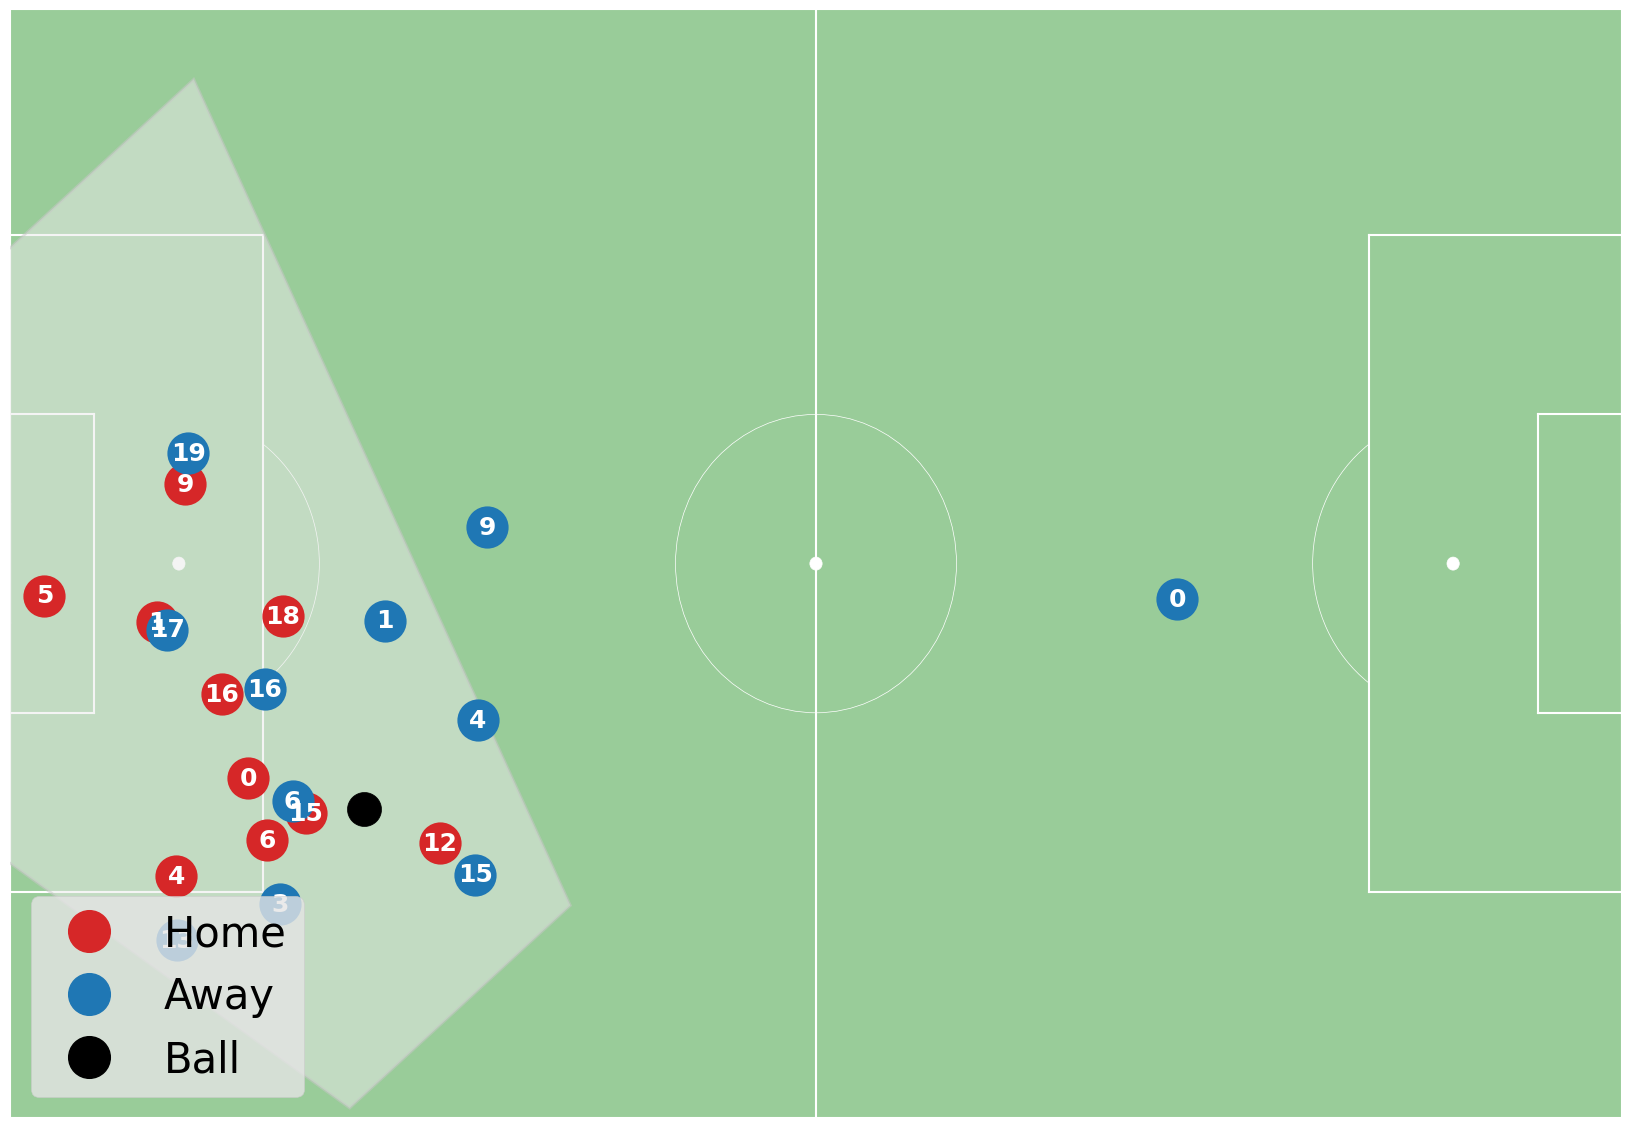

In [114]:
before_maigin = 0
after_margin = 0

period_traces = tracking_data[tracking_data["period_id"] == highlight.period_id].reset_index(drop=True)
closest_idx = period_traces["time"].sub(highlight.time_seconds).abs().idxmin()
trace = period_traces.loc[[closest_idx]]#.drop(columns=["B00_x", "B00_y"])

if all_df_events.at[event_idx, "period_id"] == 1:
    rotate_team = "H"
else:
    rotate_team = "A"
    
if test_dataset.play_left_to_right:
    away_x_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_x")]
    away_y_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_y")]
    trace[away_x_cols] = config.field_length - trace[away_x_cols].values
    trace[away_y_cols] = config.field_width - trace[away_y_cols].values
    
# 시각화: 360에 포착되지 않는 선수 제거
# except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01"]
# trace = trace.drop(columns=[f"{key}_{coord}" for key in except_id for coord in ["x", "y"]])

if rotate_team == highlight.team[0]:
    ball_pos = np.array([[config.field_length-highlight.start_x, config.field_width-highlight.start_y]])
else:
    ball_pos = np.array([[highlight.start_x, highlight.start_y]])

visible_area = compute_camera_coverage(ball_pos, 
                                    camera_info=(0, -20, 20, 30),
                                    pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
# snapshot.plot(save_format="png")
snapshot.plot(color="green")

visible_area:  ((array([-24.4527808]), array([32.22154498])), (array([11.96770943]), array([63.70157498])), (array([36.50208207]), array([13.03664581])), (array([22.12707376]), array([0.61161556])))
not exist ball trajectory


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

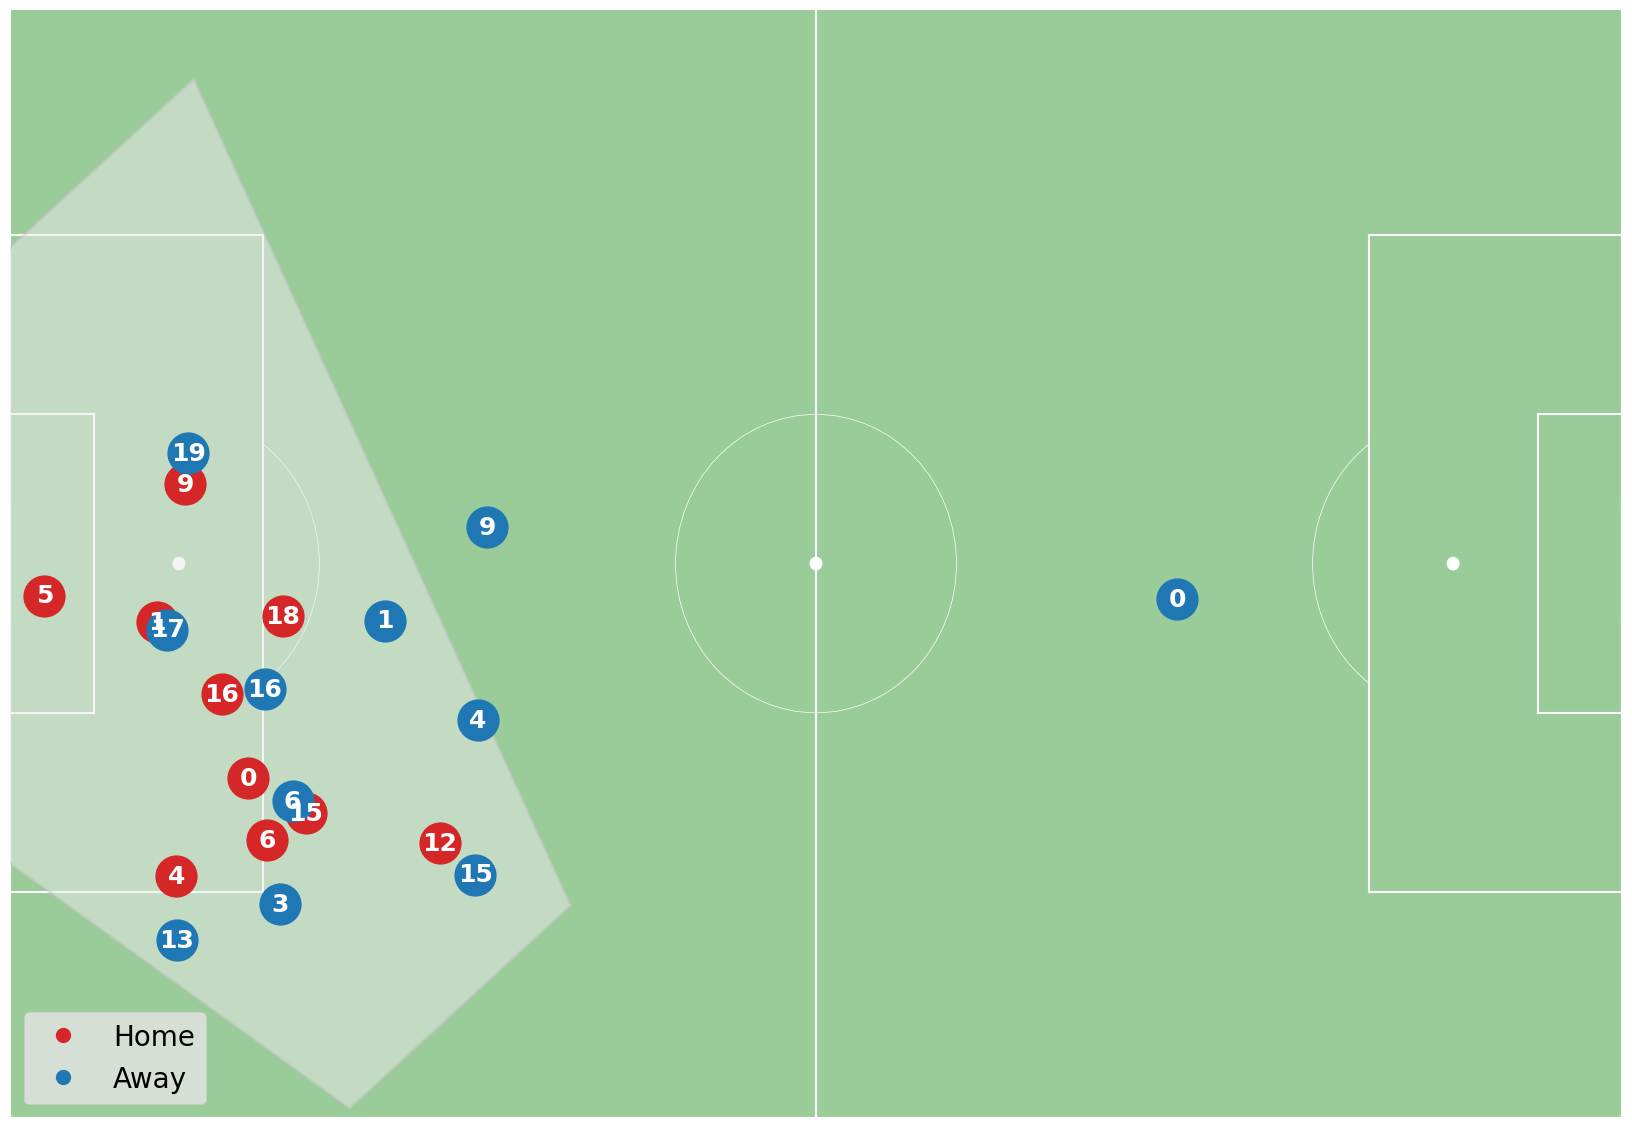

In [115]:
row = {}
for pid, (x, y) in df1.loc[event_idx, "target"].items():
    row[f"{pid}_x"] = x
    row[f"{pid}_y"] = y
trace = pd.DataFrame.from_dict(row, orient='index').T

if test_dataset.play_left_to_right:
    away_x_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_x")]
    away_y_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_y")]
    trace[away_x_cols] = config.field_length - trace[away_x_cols].values
    trace[away_y_cols] = config.field_width - trace[away_y_cols].values

visible_area = compute_camera_coverage(ball_pos, 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
snapshot.plot()

visible_area:  ((array([-24.4527808]), array([32.22154498])), (array([11.96770943]), array([63.70157498])), (array([36.50208207]), array([13.03664581])), (array([22.12707376]), array([0.61161556])))
not exist ball trajectory


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

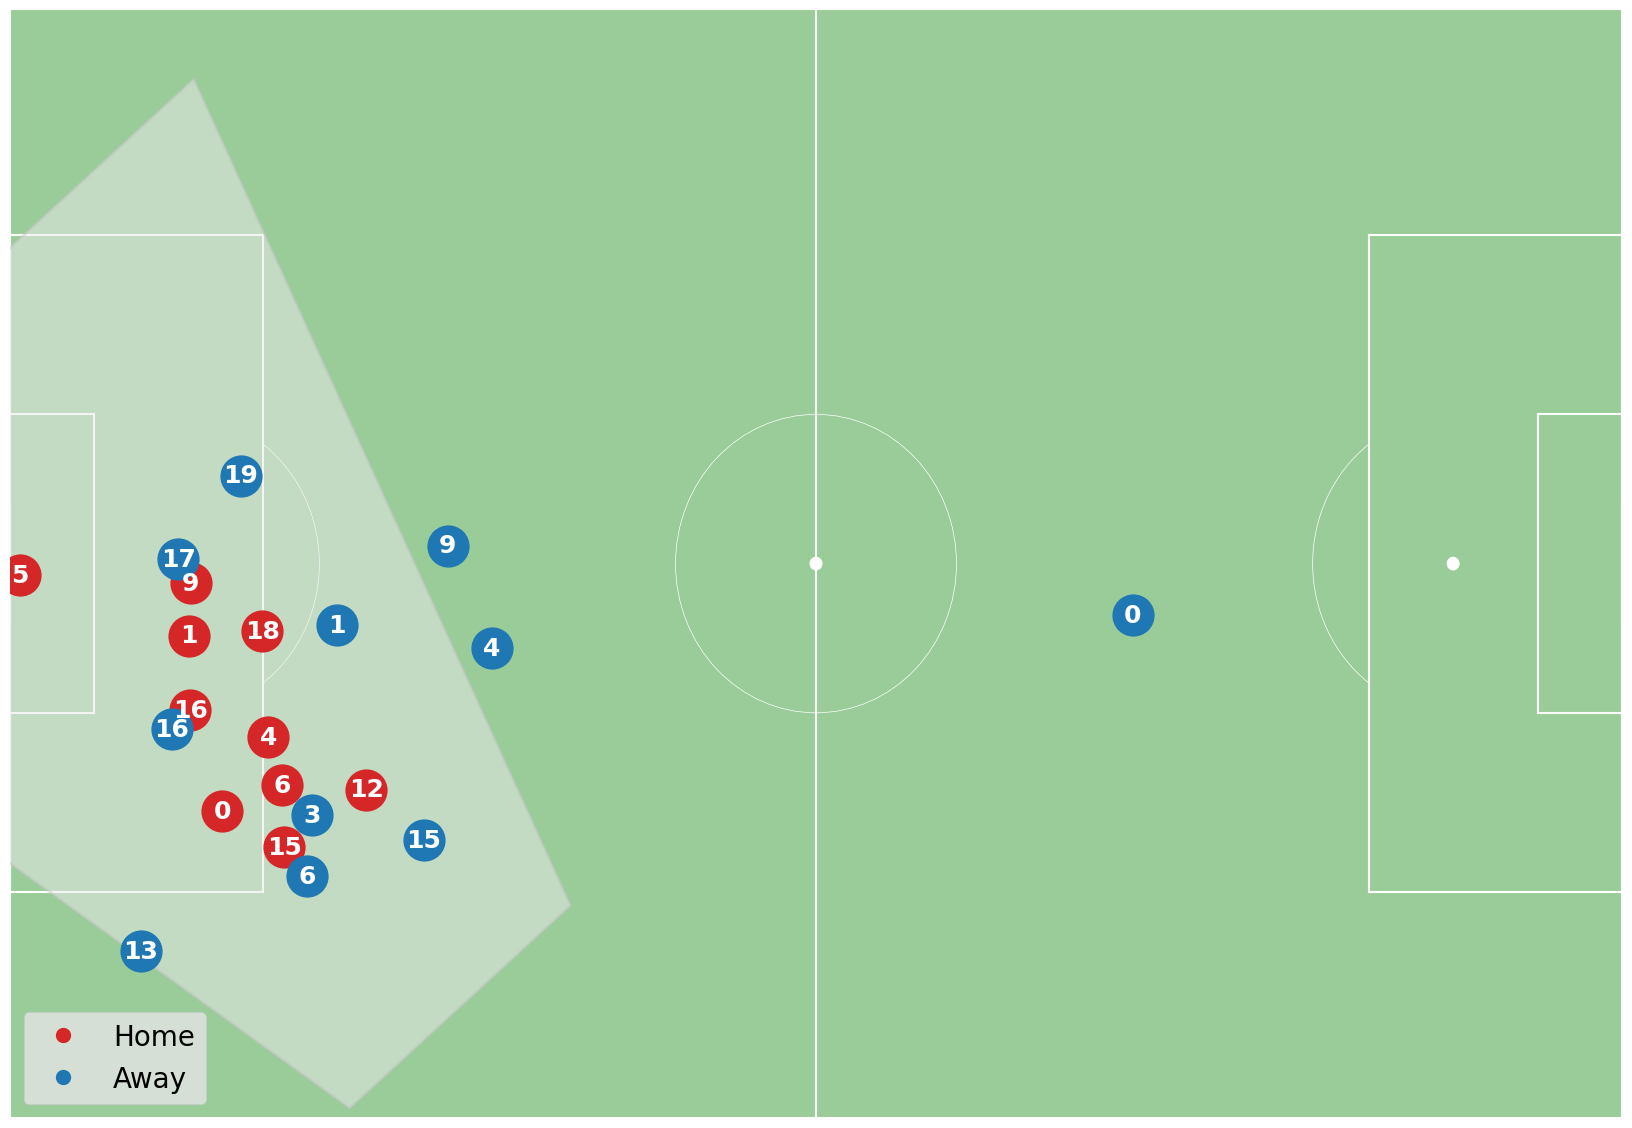

In [116]:
row = {}
for pid, (x, y) in df.loc[event_idx, "pred"].items():
    row[f"{pid}_x"] = x
    row[f"{pid}_y"] = y
trace = pd.DataFrame.from_dict(row, orient='index').T

if test_dataset.play_left_to_right:
    away_x_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_x")]
    away_y_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_y")]
    trace[away_x_cols] = config.field_length - trace[away_x_cols].values
    trace[away_y_cols] = config.field_width - trace[away_y_cols].values

# 시각화: 360에 포착되지 않는 선수 제거
# except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01", "A05","A00","A09","A08","H16", "H15","H07"]
# except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01"]
# trace = trace.drop(columns=[f"{key}_{coord}" for key in except_id for coord in ["x", "y"]])

visible_area = compute_camera_coverage(ball_pos, 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
snapshot.plot()

visible_area:  ((array([-24.4527808]), array([32.22154498])), (array([11.96770943]), array([63.70157498])), (array([36.50208207]), array([13.03664581])), (array([22.12707376]), array([0.61161556])))
not exist ball trajectory


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

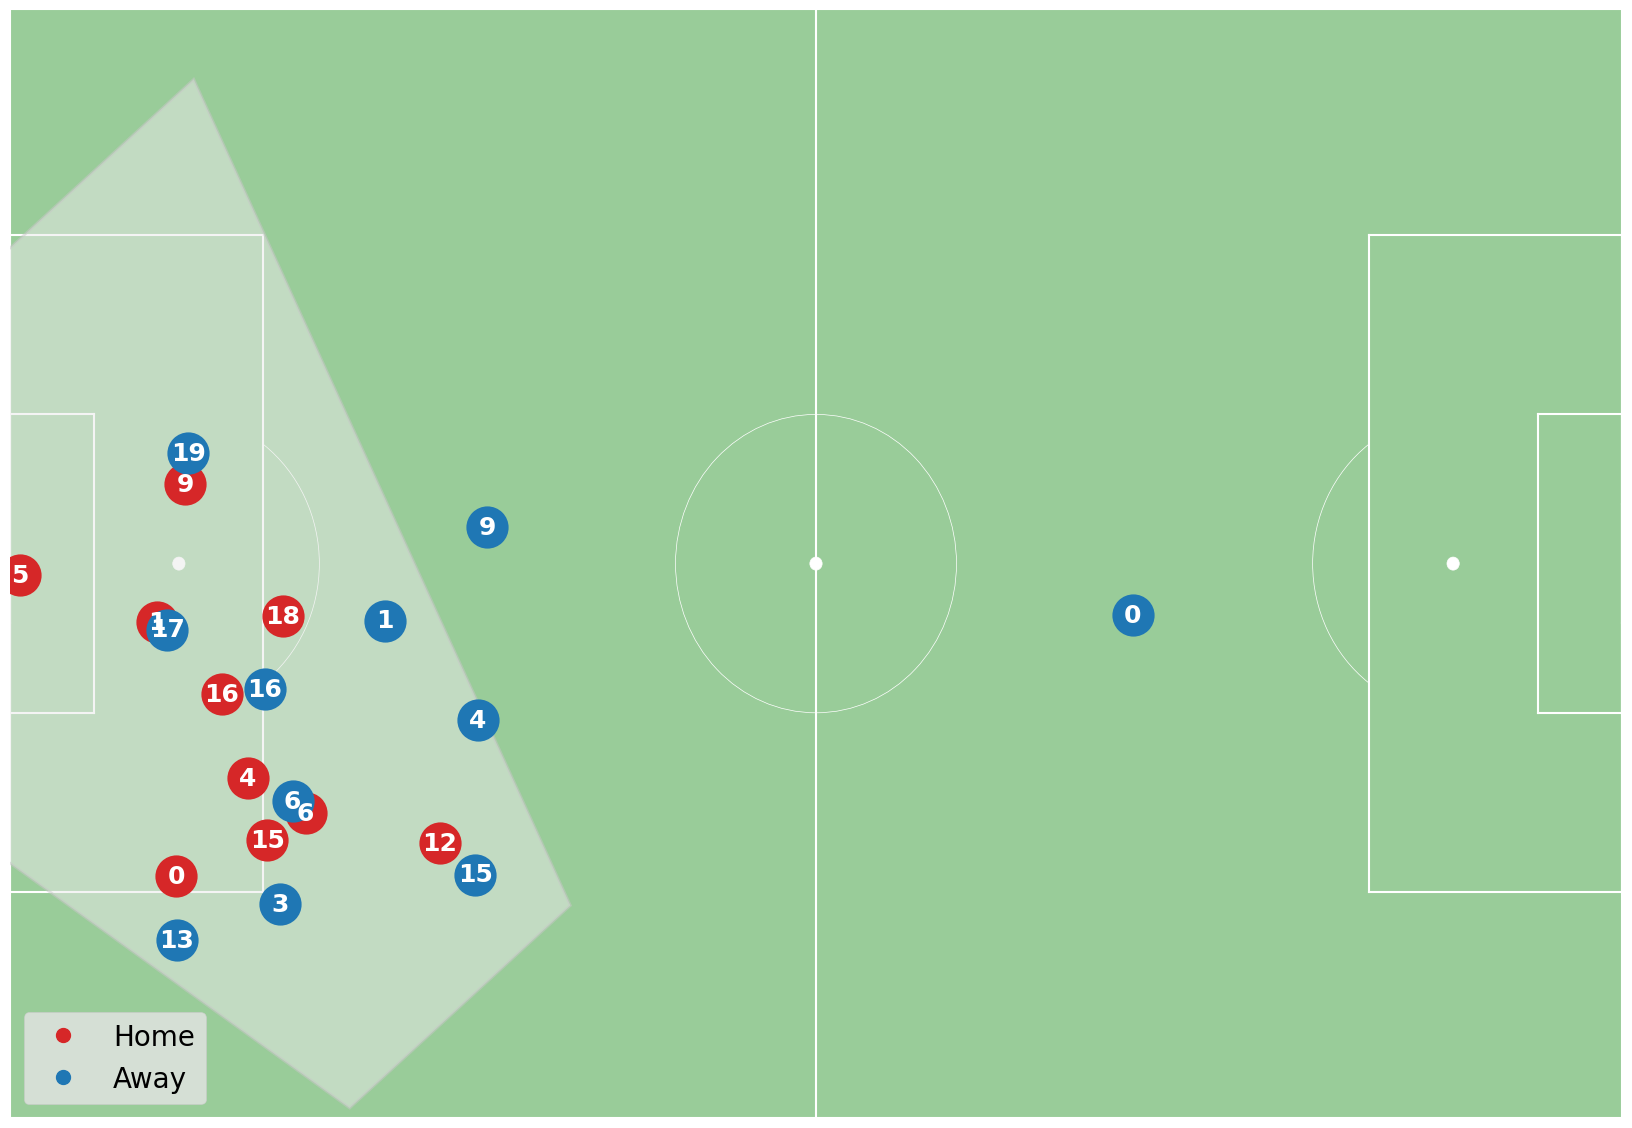

In [118]:
row = {}
for pid, (x, y) in df1.loc[event_idx, "pred"].items():
    row[f"{pid}_x"] = x
    row[f"{pid}_y"] = y
trace = pd.DataFrame.from_dict(row, orient='index').T

if test_dataset.play_left_to_right:
    away_x_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_x")]
    away_y_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_y")]
    trace[away_x_cols] = config.field_length - trace[away_x_cols].values
    trace[away_y_cols] = config.field_width - trace[away_y_cols].values

# 시각화: 360에 포착되지 않는 선수 제거
# except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01", "A05","A00","A09","A08","H16", "H15","H07"]
# except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01"]
# trace = trace.drop(columns=[f"{key}_{coord}" for key in except_id for coord in ["x", "y"]])

visible_area = compute_camera_coverage(ball_pos, 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
snapshot.plot()

## Pitch Control

In [119]:
import datatools.pitch_control as pc
import datatools.visualization as ut

In [120]:
g_id = all_df_events.game_id.unique()[0]
print("Pitch Control for Game ID:", g_id)

df_events = all_df_events[all_df_events.game_id == g_id]
df_preds = df.loc[df_events.index].reset_index(drop=True)
df_preds1 = df1.loc[df_events.index].reset_index(drop=True)

Pitch Control for Game ID: DFL-MAT-J03YKM


In [121]:
df_events = df_events.reset_index(drop=True)
print(f"events shape: {df_events.shape}")
df_events.head(2)

events shape: (1649, 18)


,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,team,game_id,start_x,start_y,position,related_x,related_y,related_id
0,KickOff_Play_Pass,0.000,DFL-CLU-00000V,DFL-OBJ-J01GLO,NaN,2024-04-06 15:30:00.520000+02:00,0.0,0.0,"{'TeamLeft': 'DFL-CLU-00000B', 'GameSection': ...",1,Home,DFL-MAT-J03YKM,53.130000,33.49000,STR,52.330000,35.050000,DFL-OBJ-J01GUA
1,Play_Pass,0.739,DFL-CLU-00000V,DFL-OBJ-J01GUA,NaN,2024-04-06 15:30:01.259000+02:00,0.0,0.0,"{'PlayOrigin': 'ownHalf', 'FromOpenPlay': 'tru...",1,Home,DFL-MAT-J03YKM,52.080015,35.52003,HL,30.130038,29.559939,DFL-OBJ-J01GQO


In [122]:
print(f"pred shape: {df_preds.shape}")
df_preds.head(2)

pred shape: (1649, 6)


,pred,target,avg_dist,x_dist,y_dist,distance
0,"{'A00': (10.090045928955078, 33.85322189331055...","{'A00': (2.940000057220459, 33.93000030517578)...",6.458981,4.941514,3.157556,142.097589
1,"{'A00': (9.762303352355957, 33.8808708190918),...","{'A00': (5.070000171661377, 33.95000076293945)...",6.373811,4.955885,3.224998,140.223852


In [123]:
print(f"pred1 shape: {df_preds1.shape}")
df_preds1.head(2)

pred1 shape: (1649, 6)


,pred,target,avg_dist,x_dist,y_dist,distance
0,"{'A00': (10.090045928955078, 33.85322189331055...","{'A00': (2.940000057220459, 33.93000030517578)...",4.963802,3.936771,2.542964,109.203645
1,"{'A00': (9.762303352355957, 33.8808708190918),...","{'A00': (5.070000171661377, 33.95000076293945)...",5.245142,4.369039,2.471025,115.393116


In [124]:
params = pc.default_model_params()
params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'lambda_gk': 12.899999999999999,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

In [125]:
team_sheets["tracking_id"] = team_sheets.apply(
    lambda t: f'{t["team"][0]}{t["xID"]:02d}', 
    axis=1
)
team_sheets.head(2)

,player,position,team,jID,player_id,team_id,xID,tracking_id
0,C. Trimmel,DRM,Home,28,DFL-OBJ-0002FX,DFL-CLU-00000V,0,H00
1,K. Vogt,IVZ,Home,2,DFL-OBJ-000040,DFL-CLU-00000V,1,H01


In [126]:
team_sheets_lookup = {
    row["tracking_id"]: {
        "player_id": row["player_id"],
        "team_id":   row["team_id"],
        "position":  row["position"],
        "team": row["team"]
    }
    for _, row in team_sheets.iterrows()
}
team_sheets_lookup

{'H00': {'player_id': 'DFL-OBJ-0002FX',
  'team_id': 'DFL-CLU-00000V',
  'position': 'DRM',
  'team': 'Home'},
 'H01': {'player_id': 'DFL-OBJ-000040',
  'team_id': 'DFL-CLU-00000V',
  'position': 'IVZ',
  'team': 'Home'},
 'H02': {'player_id': 'DFL-OBJ-00001D',
  'team_id': 'DFL-CLU-00000V',
  'position': 'None',
  'team': 'Home'},
 'H03': {'player_id': 'DFL-OBJ-0000UE',
  'team_id': 'DFL-CLU-00000V',
  'position': 'None',
  'team': 'Home'},
 'H04': {'player_id': 'DFL-OBJ-0001EA',
  'team_id': 'DFL-CLU-00000V',
  'position': 'DMZ',
  'team': 'Home'},
 'H05': {'player_id': 'DFL-OBJ-0028P2',
  'team_id': 'DFL-CLU-00000V',
  'position': 'TW',
  'team': 'Home'},
 'H06': {'player_id': 'DFL-OBJ-002GDG',
  'team_id': 'DFL-CLU-00000V',
  'position': 'HR',
  'team': 'Home'},
 'H07': {'player_id': 'DFL-OBJ-002860',
  'team_id': 'DFL-CLU-00000V',
  'position': 'None',
  'team': 'Home'},
 'H08': {'player_id': 'DFL-OBJ-J019PZ',
  'team_id': 'DFL-CLU-00000V',
  'position': 'DLM',
  'team': 'Home'},


In [127]:
period_tracking_dict = {
    period_id: df.reset_index(drop=True)
    for period_id, df in tracking_data.groupby("period_id")
}
period_tracking_dict

{1:        H00_x  H00_y  H01_x  H01_y  H02_x  H02_y  H03_x  H03_y  H04_x  H04_y  \
 0      46.92  27.31  30.98  37.63    NaN    NaN    NaN    NaN  46.59  39.14   
 1      46.95  27.36  30.94  37.63    NaN    NaN    NaN    NaN  46.62  39.11   
 2      46.98  27.40  30.91  37.64    NaN    NaN    NaN    NaN  46.64  39.10   
 3      47.03  27.44  30.88  37.64    NaN    NaN    NaN    NaN  46.66  39.07   
 4      47.07  27.49  30.83  37.65    NaN    NaN    NaN    NaN  46.67  39.05   
 ...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
 78845  36.99  24.90  23.56  34.75    NaN    NaN    NaN    NaN  40.94  37.50   
 78846  36.99  24.90  23.62  34.76    NaN    NaN    NaN    NaN  40.99  37.56   
 78847  36.99  24.90  23.66  34.77    NaN    NaN    NaN    NaN  41.02  37.60   
 78848  36.98  24.90  23.71  34.78    NaN    NaN    NaN    NaN  41.07  37.65   
 78849  36.98  24.90  23.75  34.80    NaN    NaN    NaN    NaN  41.11  37.70   
 
        ...  A18_vx  A18_vy  A18_sp

In [128]:
results_df = []
from tqdm import tqdm
for row in tqdm(df_events.itertuples()):
    if row.Index != event_idx:
        continue

    event_id = row.Index

    copy_tracking_data = period_tracking_dict[row.period_id]
    closest_idx = copy_tracking_data["time"].sub(row.time_seconds).abs().idxmin()

    preds = df_preds.loc[event_idx, "pred"]
    preds1 = df_preds1.loc[event_idx, "pred"]
    targets = df_preds.loc[event_idx, "target"]
    assert set(preds.keys()) == set(preds1.keys()) == set(targets.keys()), (f"Key mismatch for event {event_id}")

    for key in preds.keys():
        pred_x, pred_y = preds[key]
        pred_x1, pred_y1 = preds1[key]
        act_x, act_y = targets[key]
        position = team_sheets_lookup[key]["position"]

        results_df.append({
            "key": key,
            "period_id": row.period_id,
            "event_id": event_id,
            "team_id": team_sheets_lookup[key]["team"], # Home or Away
            "team_on_ball": row.team_id == team_sheets_lookup[key]["team_id"], # tea_id
            "player_on_ball": row.player_id == team_sheets_lookup[key]["player_id"], # player_id
            "position": position,
            "pred_x": pred_x if key[0] == "H" else config.field_length - pred_x,
            "pred_y": pred_y if key[0] == "H" else config.field_width - pred_y,
            "pred_x1": pred_x1 if key[0] == "H" else config.field_length - pred_x1,
            "pred_y1": pred_y1 if key[0] == "H" else config.field_width - pred_y1,
            "act_x": act_x if key[0] == "H" else config.field_length - act_x,
            "act_y": act_y if key[0] == "H" else config.field_width - act_y,
            "ballx": copy_tracking_data.at[closest_idx, "B00_x"], # actual location
            "bally": copy_tracking_data.at[closest_idx, "B00_y"],
        })

results_df = pd.DataFrame(results_df)
results_df

1649it [00:00, 281314.87it/s]


,key,period_id,event_id,team_id,team_on_ball,player_on_ball,position,pred_x,pred_y,pred_x1,pred_y1,act_x,act_y,ballx,bally
0,A00,2,1011,Away,True,False,TW,73.133026,30.862450,73.133026,30.862450,76.039999,31.800003,23.06,18.96
1,A01,2,1011,Away,True,False,DML,21.305153,30.230728,24.430000,30.509998,24.430000,30.509998,23.06,18.96
2,A03,2,1011,Away,True,False,DMR,19.660713,18.576622,17.610001,13.130001,17.610001,13.130001,23.06,18.96
3,A04,2,1011,Away,True,False,IVZ,31.382408,28.835464,30.459999,24.419998,30.459999,24.419998,23.06,18.96
4,A06,2,1011,Away,True,True,DLM,19.357101,14.846695,18.410004,19.439999,18.410004,19.439999,23.06,18.96
5,A09,2,1011,Away,True,False,IVR,28.501381,35.109566,31.089996,36.250000,31.089996,36.250000,23.06,18.96
6,A13,2,1011,Away,True,False,OHR,8.522156,10.244141,10.849998,10.889999,10.849998,10.889999,23.06,18.96
7,A15,2,1011,Away,True,False,IVL,26.947296,17.048119,30.300003,14.930000,30.300003,14.930000,23.06,18.96
8,A16,2,1011,Away,True,False,ZO,10.554916,23.841675,16.589996,26.279999,16.589996,26.279999,23.06,18.96
9,A17,2,1011,Away,True,False,STZ,10.965012,34.261459,10.239998,29.950001,10.239998,29.950001,23.06,18.96


In [129]:
df_events.loc[[event_id]]

,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,team,game_id,start_x,start_y,position,related_x,related_y,related_id
1011,Play_Pass,772.969,DFL-CLU-00000B,DFL-OBJ-J016J2,NaN,2024-04-06 16:52:58.299000+02:00,12.0,52.0,"{'PlayOrigin': 'oppositionHalf', 'FromOpenPlay...",2,Away,DFL-MAT-J03YKM,86.589982,48.559953,DLM,76.999996,51.159971,DFL-OBJ-J01EAQ


In [130]:
event_id = event_idx#389 #1게임인덱스의 47: 강력한 후보, 0번 인덱스의 45번, 1번인덱스의 389 ,1번인덱스의 50번, 1번인덱스의 181번
results_df[results_df["event_id"] == event_id]

,key,period_id,event_id,team_id,team_on_ball,player_on_ball,position,pred_x,pred_y,pred_x1,pred_y1,act_x,act_y,ballx,bally
0,A00,2,1011,Away,True,False,TW,73.133026,30.862450,73.133026,30.862450,76.039999,31.800003,23.06,18.96
1,A01,2,1011,Away,True,False,DML,21.305153,30.230728,24.430000,30.509998,24.430000,30.509998,23.06,18.96
2,A03,2,1011,Away,True,False,DMR,19.660713,18.576622,17.610001,13.130001,17.610001,13.130001,23.06,18.96
3,A04,2,1011,Away,True,False,IVZ,31.382408,28.835464,30.459999,24.419998,30.459999,24.419998,23.06,18.96
4,A06,2,1011,Away,True,True,DLM,19.357101,14.846695,18.410004,19.439999,18.410004,19.439999,23.06,18.96
5,A09,2,1011,Away,True,False,IVR,28.501381,35.109566,31.089996,36.250000,31.089996,36.250000,23.06,18.96
6,A13,2,1011,Away,True,False,OHR,8.522156,10.244141,10.849998,10.889999,10.849998,10.889999,23.06,18.96
7,A15,2,1011,Away,True,False,IVL,26.947296,17.048119,30.300003,14.930000,30.300003,14.930000,23.06,18.96
8,A16,2,1011,Away,True,False,ZO,10.554916,23.841675,16.589996,26.279999,16.589996,26.279999,23.06,18.96
9,A17,2,1011,Away,True,False,STZ,10.965012,34.261459,10.239998,29.950001,10.239998,29.950001,23.06,18.96


In [140]:
from matplotlib.colors import TwoSlopeNorm

# Generate Pitch Control for predictor models
def calculate_model_pitch_control(results_df, event_id, output, home_left_to_right = False):
    event_df = results_df[results_df["event_id"] == event_id].copy()
    
    if output == "pred":
        event_df["x"] = event_df["pred_x"].copy()
        event_df["y"] = event_df["pred_y"].copy()
    elif output == "pred1":
        event_df["x"] = event_df["pred_x1"].copy()
        event_df["y"] = event_df["pred_y1"].copy()
    elif output == "act":
        event_df["x"] = event_df["act_x"].copy()
        event_df["y"] = event_df["act_y"].copy()
    else:
        raise ValueError(f"Unknown output type: {output}")
    
    # pitch control은 항상 홈팀이 왼쪽에서 오른쪽으로 공격한다고 가정함.
    if not home_left_to_right:
        event_df["x"] = config.field_length - event_df["x"].values
        event_df["y"] = config.field_width - event_df["y"].values

    PPCFa, _, _ = pc.generate_pitch_control_for_event(event_df.iloc[0], event_df, params, 
                                                       field_dimen=(config.field_length, config.field_width,), 
                                                       n_grid_cells_x=52, n_grid_cells_y=52*0.75, offsides=False, #52.2
    )
    
    fig, ax = pc.plot_pitchcontrol_for_event(PPCFa, event_df.iloc[0], event_df)
    fig.set_size_inches(12,8)

    return PPCFa, ax, event_df

def plot_pitchcontrol(e, event_id, PPCF, locs, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (105.0, 68)):
    highlight = e.loc[event_id]

    row = {}
    for r in locs.itertuples():
        row[f"{r.key}_x"] = r.x
        row[f"{r.key}_y"] = r.y
    # row["B00_x"] = locs.iloc[0].ballx
    # row["B00_y"] = locs.iloc[0].bally
    trace = pd.DataFrame.from_dict(row, orient='index').T

    # 시각화: 360에 포착되지 않는 선수 제거
    # except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01", "A05","A00","A09","A08","H16", "H15","H07"]
    # trace = trace.drop(columns=[f"{key}_{coord}" for key in except_id for coord in ["x", "y"]])

    visible_area = compute_camera_coverage(ball_pos,
                                        camera_info=(0, -20, 20, 30),
                                        pitch_size=(config.field_length, config.field_width))

    snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
    fig, ax = snapshot.plot(color="white")

    # 컬러바 생성
    # cbar = fig.colorbar(pc, orientation='vertical')
    # cbar.set_label('Probability')
    
    norm = TwoSlopeNorm(vmin=0.0, vcenter=0.5, vmax=np.max(PPCF))
    # pc = ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]),
    #             norm=norm, cmap='bwr', alpha=0.5)

    pc = ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]), 
                vmin=0.0, vmax=1.0, cmap='bwr', alpha=0.5)
    
    # for i in range(PPCF.shape[0]):
    #     for j in range(PPCF.shape[1]):
    #         val = PPCF[i, j]
    #         if val > 0.01:  # 너무 작은 값은 생략
    #             ax.text(
    #                 j * (field_dimen[0] / PPCF.shape[1]) + (field_dimen[0] / (2 * PPCF.shape[1])),  # x
    #                 i * (field_dimen[1] / PPCF.shape[0]) + (field_dimen[1] / (2 * PPCF.shape[0])),  # y
    #                 f"{val:.2f}",
    #                 color='black',
    #                 ha='center',
    #                 va='center',
    #                 fontsize=6,
    #                 alpha=0.8
    #             )
    norm = TwoSlopeNorm(vmin=0.0, vcenter=0.5, vmax=1.0)

    # pc = ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]),cmap='bwr',alpha=0.5, norm=norm)
    # cbar = fig.colorbar(pc, orientation='vertical')
    # cbar.set_label('Probability')

    return fig, ax

/root/geonhee/PlayerImputer/datatools/pitch_control.py:245: RuntimeWarning: divide by zero encountered in scalar divide
  checksum = np.sum( PPCFa + PPCFd ) / float(count)#float(n_grid_cells_y*n_grid_cells_x )


not exist ball trajectory


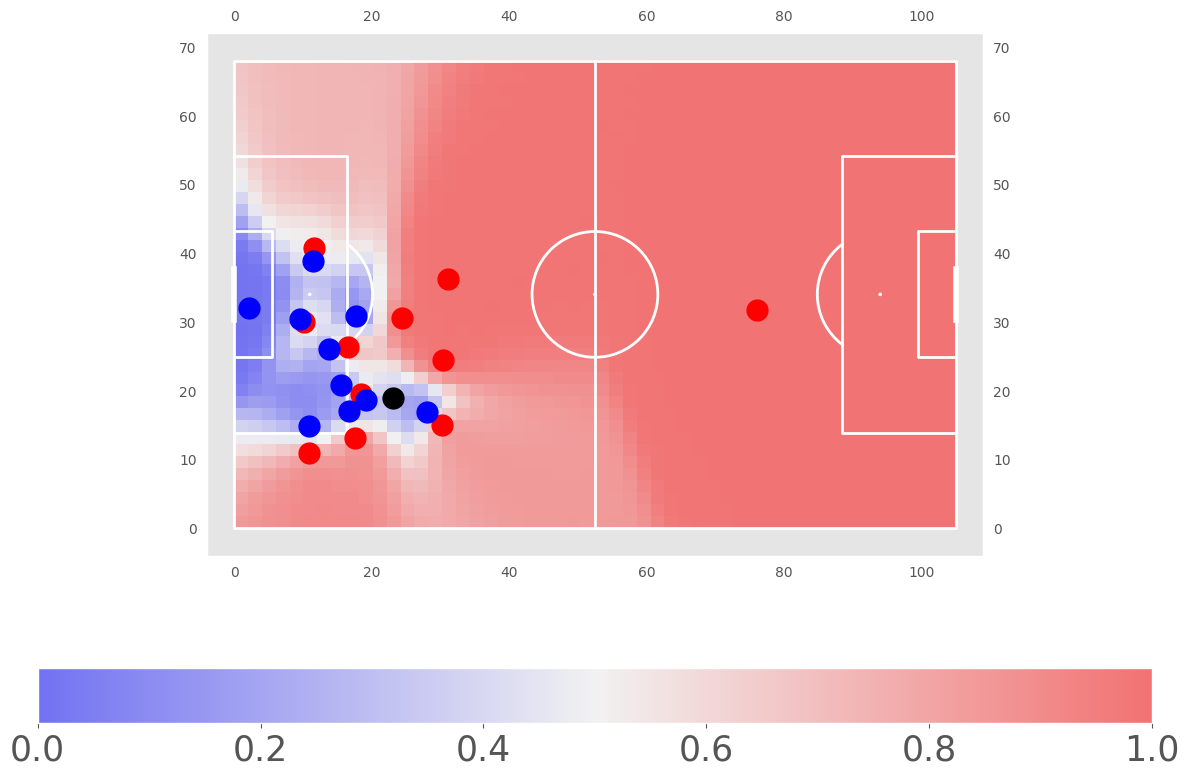

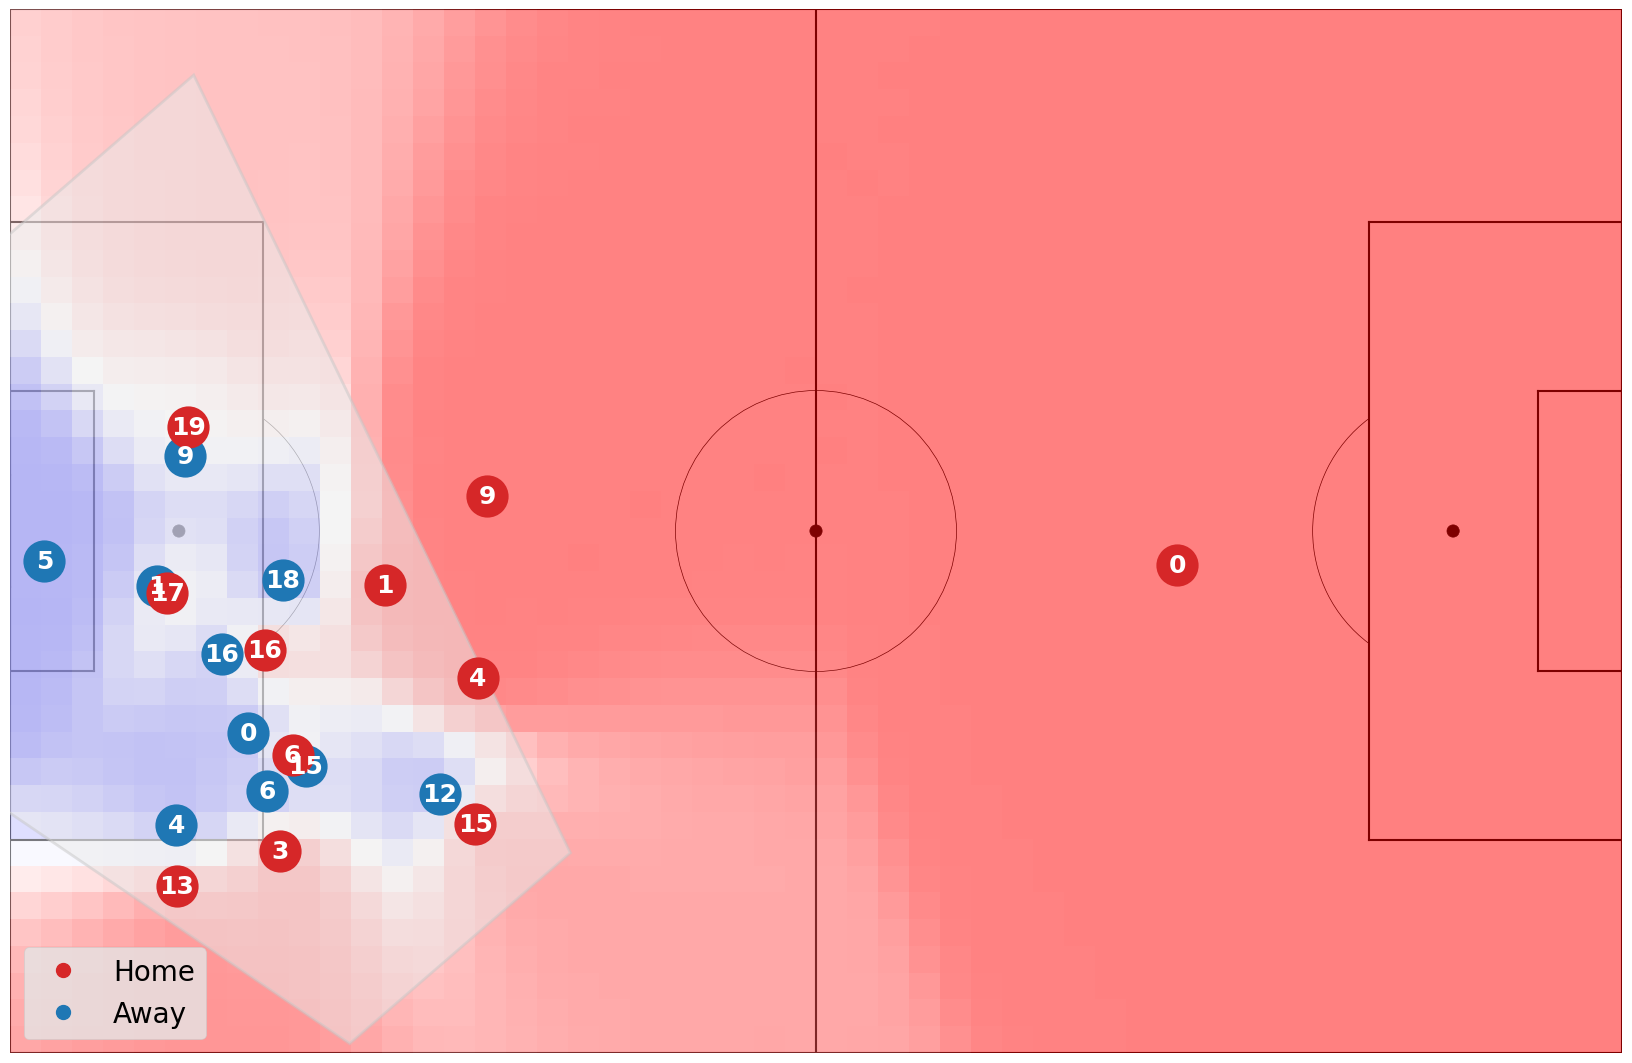

In [148]:
act_PPCFa, _, event_df = calculate_model_pitch_control(results_df, event_id=event_id, output="act", home_left_to_right=True)
fig, _ = plot_pitchcontrol(e=df_events, event_id=event_id, PPCF=act_PPCFa, locs=event_df)

# fig.savefig("true_pitch_control.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

/root/geonhee/PlayerImputer/datatools/pitch_control.py:245: RuntimeWarning: divide by zero encountered in scalar divide
  checksum = np.sum( PPCFa + PPCFd ) / float(count)#float(n_grid_cells_y*n_grid_cells_x )


not exist ball trajectory


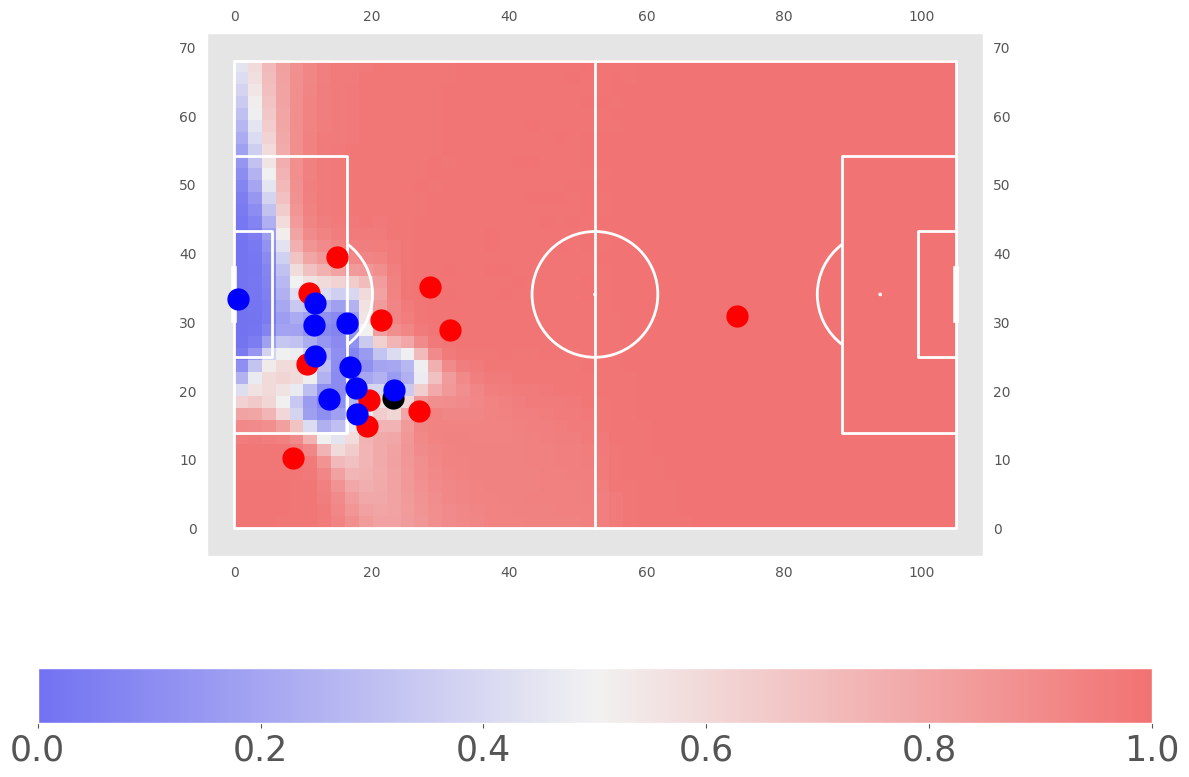

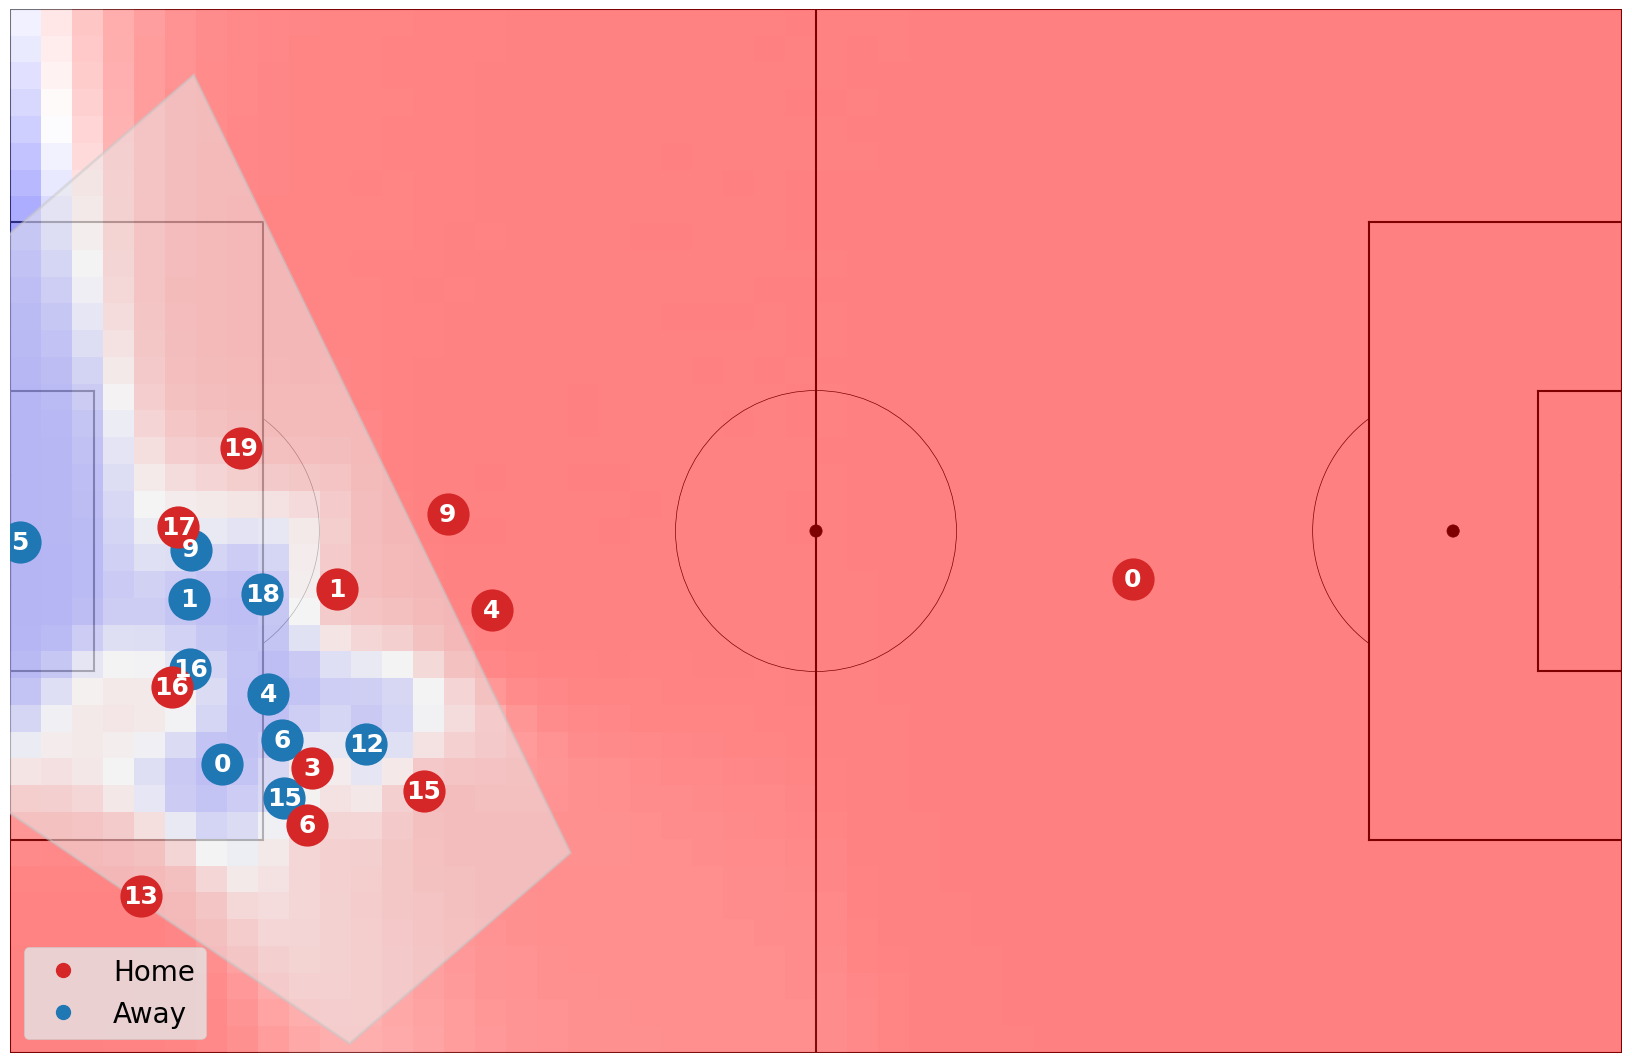

In [149]:
pred_PPCFa, _, event_df = calculate_model_pitch_control(results_df, event_id=event_id, output="pred", home_left_to_right=True)
fig, _ = plot_pitchcontrol(e=df_events, event_id=event_id, PPCF=pred_PPCFa, locs=event_df)

# fig.savefig("xgboost_pitch_control.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

/root/geonhee/PlayerImputer/datatools/pitch_control.py:245: RuntimeWarning: divide by zero encountered in scalar divide
  checksum = np.sum( PPCFa + PPCFd ) / float(count)#float(n_grid_cells_y*n_grid_cells_x )


not exist ball trajectory


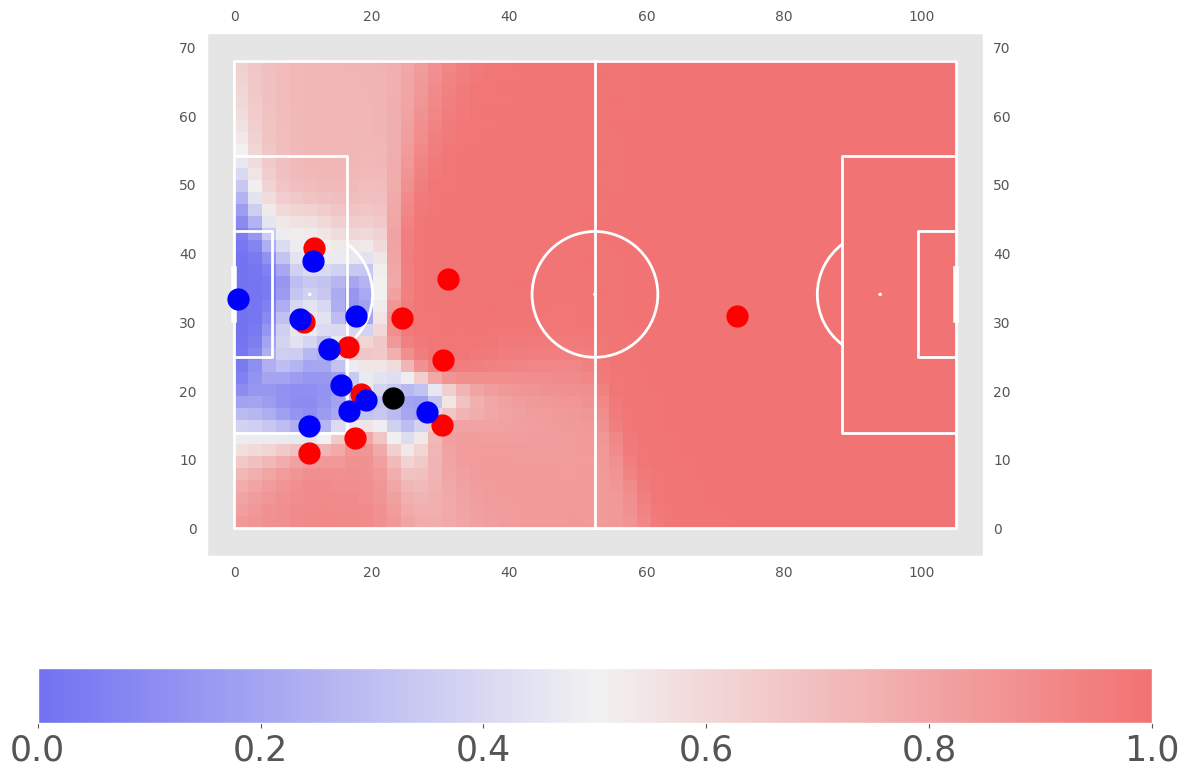

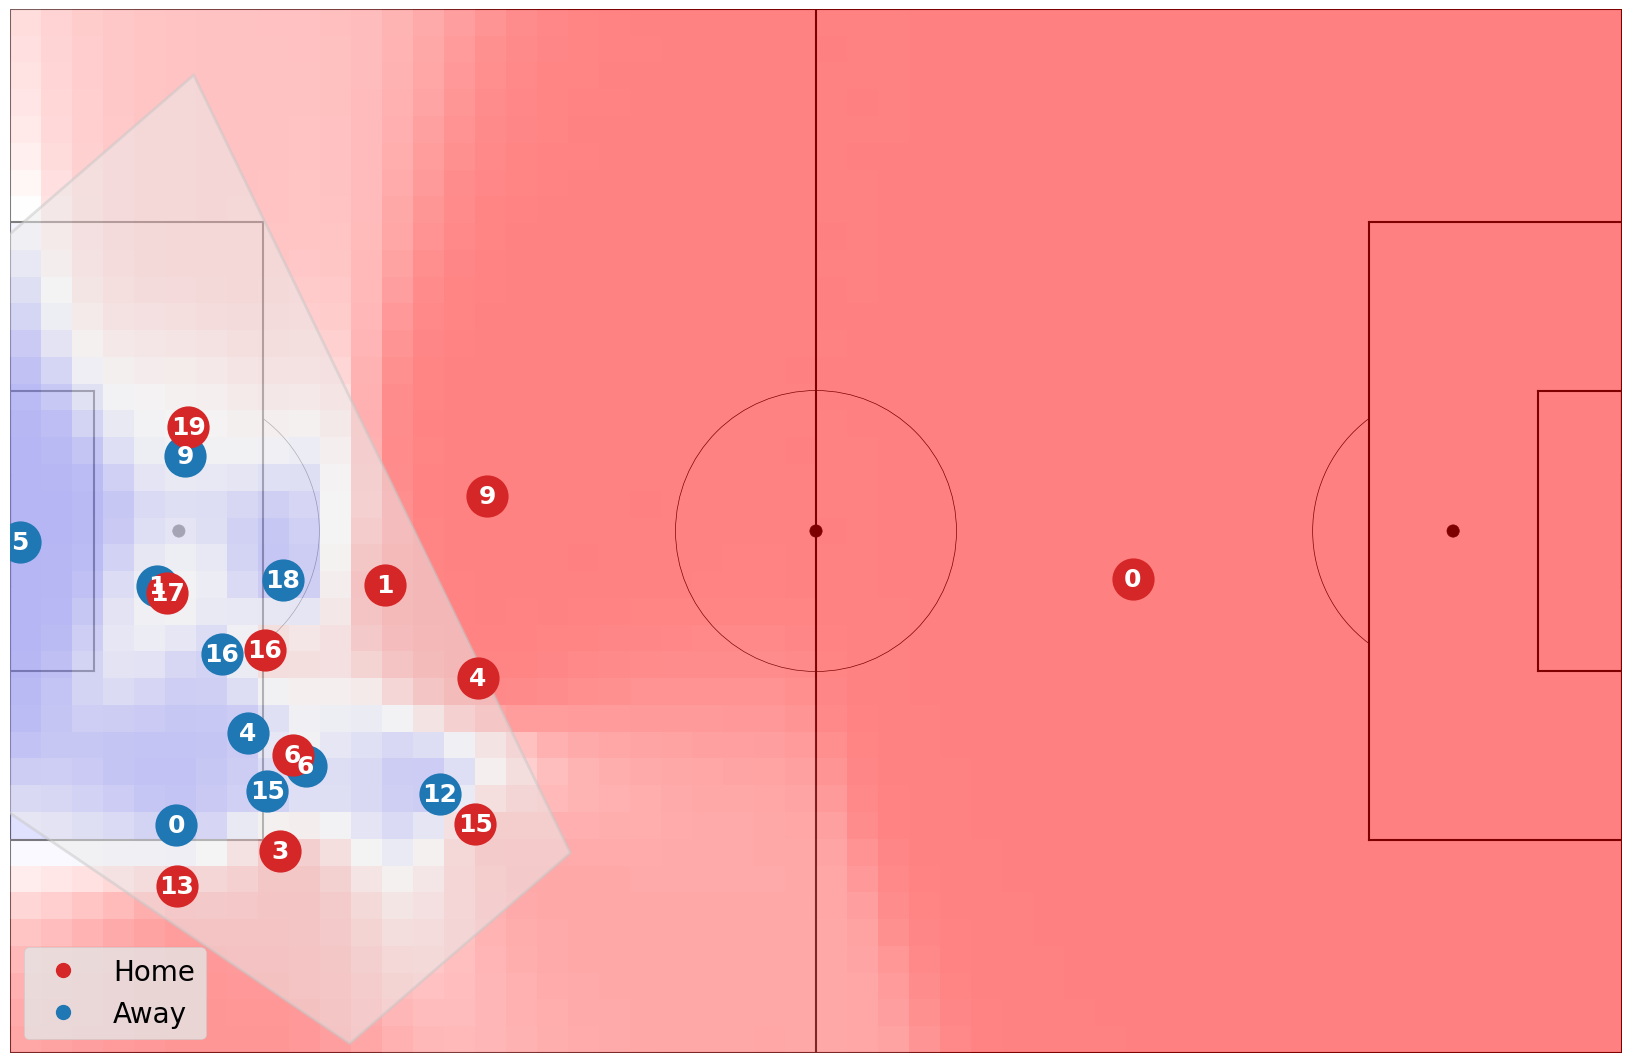

In [150]:
pred1_PPCFa, _, event_df = calculate_model_pitch_control(results_df, event_id=event_id, output="pred1", home_left_to_right=True)
fig, _ = plot_pitchcontrol(e=df_events, event_id=event_id, PPCF=pred1_PPCFa, locs=event_df)

# fig.savefig("xgboost_pitch_control.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

In [151]:
act_PPCFa.shape, pred_PPCFa.shape, pred1_PPCFa.shape

((39, 52), (39, 52), (39, 52))

In [152]:
abs(act_PPCFa - pred_PPCFa).mean(), abs(act_PPCFa - pred1_PPCFa).mean()

(0.06769502253975522, 0.003555269035201588)